# PIK3CA phospho Trans analysis: Figure 2B

This notebook performs t-tests of phosphorylation abundance between PIK3CA hotspot mutations (E542K,E545K,and H1047R)and wildtype tumors (no PIK3CA mutation of any kind) for a proteins within PI3K-Akt signaling pathway from wikipathways. It then makes figure 2B with the most significant results that have site data for the other cancers

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats
import matplotlib.pyplot as plt
import sys 
import re
import cptac
import statsmodels.stats.multitest
import operator
import cptac.utils as u
import warnings
warnings.filterwarnings('ignore')

/Users/Lindsey/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Load CPTAC data

In [2]:
br = cptac.Brca()
endo = cptac.Endometrial()
col = cptac.Colon()

In [3]:
def rename_duplicate_cols(df):
    cols = pd.Series(df.columns[:])

    for dup in cols[cols.duplicated()].unique(): 
        cols[cols[cols == dup].index.values.tolist()] = [dup + '_' + str(i) if i != 0 else dup for i in range(sum(cols == dup))]

    # rename the columns with the cols list.
    df.columns=cols
    return df

# Get Pik3ca pathway proteins

In [4]:

prot = u.get_proteins_in_pathways('PI3K-Akt Signaling Pathway', 'wikipathways')
prot_list = list(prot.member)

phos_list = ["PIK3CA_Location","PIK3CA_Mutation"]
for gene in prot_list:
    phos = gene + "_phosphoproteomics"
    phos_list.append(phos)


# Run Wrap T-test on phosphosites in PIK3CA pathway

In [5]:
def get_trans_results(cancer, phos_list , return_result_df = True):
    phos = cancer.join_omics_to_mutations(omics_df_name = "phosphoproteomics",mutations_genes="PIK3CA", tissue_type="tumor")
    if cancer == br:
        phos = u.reduce_multiindex(df=phos, levels_to_drop=["Database_ID","Peptide"])
    if cancer == col:
        phos = u.reduce_multiindex(df=phos, levels_to_drop=["Database_ID"])

    genefilter = phos.columns.get_level_values("Name").isin(phos_list)
    phos_pik3ca = phos[phos.columns[genefilter]]
    phos_pik3ca = cptac.utils.reduce_multiindex(phos_pik3ca, flatten=True)
    
    
    phos_pik3ca['PIK3CA_Mutation'] = [','.join(map(str, l)) for l in phos_pik3ca['PIK3CA_Mutation']]
    phos_pik3ca['PIK3CA_Location'] = [','.join(map(str, l)) for l in phos_pik3ca['PIK3CA_Location']]
    phos_pik3ca  = rename_duplicate_cols(phos_pik3ca)
    hotspot = phos_pik3ca[(phos_pik3ca.PIK3CA_Location.str.contains('E542K'))| 
                    phos_pik3ca.PIK3CA_Location.str.contains('E545K')| 
                    phos_pik3ca.PIK3CA_Location.str.contains('H1047R')]
    hotspot["PIK3CA_Mutation"] = "Hotspot"
    wt = phos_pik3ca[(phos_pik3ca.PIK3CA_Mutation.str.contains('Wildtype'))]
    hotspot_wt = pd.concat([hotspot, wt])
    if return_result_df:

        cols = hotspot_wt.columns.to_list()
        cols.remove("PIK3CA_Mutation")
        cols.remove("PIK3CA_Location")
        print("n sites = " + str(len(cols)))
        phos_pval = u.wrap_ttest(hotspot_wt, 'PIK3CA_Mutation', cols,return_all=True, pval_return_corrected= True, correction_method= "FDR_bh")
        return phos_pval
    else:
        return hotspot_wt
    

# Brca

In [6]:
brca_results = get_trans_results(br,phos_list)

brca_results.head(20)

n sites = 636


,Comparison,P_Value
0,AKT2_phosphoproteomics_S34,0.048497
1,FOXO3_phosphoproteomics_T32,0.075094
2,MAP2K2_phosphoproteomics_S306,0.175429
3,GSK3B_phosphoproteomics_S9,0.175429
4,FOXO3_phosphoproteomics_S253,0.175429
5,FOXO3_phosphoproteomics_S311,0.175429
6,TSC2_phosphoproteomics_S939,0.241697
7,CSF1R_phosphoproteomics_S716,0.243040
8,IRS1_phosphoproteomics_S330,0.246305
9,IRS1_phosphoproteomics_S270,0.354867


# Endo

In [7]:
Endo_results = get_trans_results(endo,phos_list)
Endo_results.head(20)

n sites = 1281


,Comparison,P_Value
0,AKT1_phosphoproteomics_S124,0.997742
1,PKN2_phosphoproteomics_T124,0.997742
2,PKN2_phosphoproteomics_T364,0.997742
3,PKN2_phosphoproteomics_T533,0.997742
4,PKN2_phosphoproteomics_T628,0.997742
5,PKN2_phosphoproteomics_T816,0.997742
6,PKN2_phosphoproteomics_T958,0.997742
7,PKN2_phosphoproteomics_Y624,0.997742
8,PKN3_phosphoproteomics_S488,0.997742
9,PKN2_phosphoproteomics_T121,0.997742


# Colon 

In [8]:
Colon_results = get_trans_results(col,phos_list)

Colon_results.head(10)


n sites = 620


,Comparison,P_Value
0,TSC2_phosphoproteomics_S1420,0.255116
1,EGFR_phosphoproteomics_Y1092,0.602252
2,IRS1_phosphoproteomics_S636,0.732574
3,NFKB1_phosphoproteomics_S937,0.732574
4,PDGFRB_phosphoproteomics_S705,0.732574
5,PKN1_phosphoproteomics_S916,0.732574
6,EIF4B_phosphoproteomics_S504,0.732574
7,IRS1_phosphoproteomics_S629,0.732574
8,SOS1_phosphoproteomics_S1161,0.732574
9,ITGB4_phosphoproteomics_S1474,0.732574


# Make PIK3CA Figure 2B

Get dataframe of phosphoproteomic and PIK3CA mutation status

In [9]:
Colon_trans_df =  get_trans_results(col,phos_list,return_result_df=False)
Brca_trans_df =  get_trans_results(br,phos_list,return_result_df=False)
Endo_trans_df =  get_trans_results(endo,phos_list,return_result_df=False)

Make dataframe with columns that we want in the figure

In [18]:
'''
This function takes df with multiple columns phosphorylation data and mutation type and 
makes one phospho column and adds cancer site column. 
@Param df: Df with phosphoproteomic data as columns and muation status 
@Param cancer: string, name of cancer.  
'''
def formatdf(df,cancer):
  
    newdf = df[["PIK3CA_Mutation","AKT2_phosphoproteomics_S34"]]
    newdf = newdf.rename(columns={"AKT2_phosphoproteomics_S34": "Phospho"})
    newdf = newdf.assign(cancer_site = cancer + "_AKT2_S34")
    
    subset = df[["PIK3CA_Mutation","FOXO3_phosphoproteomics_S253"]]
    subset = subset.rename(columns={"FOXO3_phosphoproteomics_S253": "Phospho"})
    subset = subset.assign(cancer_site = cancer + "_FOXO3_S253")
    newdf = newdf.append(subset)
    
    subset = df[["PIK3CA_Mutation","MAP2K2_phosphoproteomics_S306"]]
    subset = subset.rename(columns={"MAP2K2_phosphoproteomics_S306": "Phospho"})
    subset = subset.assign(cancer_site = cancer + "_MAP2K2_S306")
    newdf = newdf.append(subset)
    
    
    if cancer == "CO":
        subset= df[["PIK3CA_Mutation","GSK3B_phosphoproteomics_S9"]]
        subset = subset.rename(columns={"GSK3B_phosphoproteomics_S9": "Phospho"})
        subset = subset.assign(cancer_site = cancer + "_GSK3B_S9")
        newdf = newdf.append(subset)
        return newdf
    else:
        subset = df[["PIK3CA_Mutation","FOXO3_phosphoproteomics_T32"]]
        subset = subset.rename(columns={"FOXO3_phosphoproteomics_T32": "Phospho"})
        subset = subset.assign(cancer_site = cancer + "_FOXO3_T32")
        newdf = newdf.append(subset)
        
        subset= df[["PIK3CA_Mutation","GSK3B_phosphoproteomics_S9"]]
        subset = subset.rename(columns={"GSK3B_phosphoproteomics_S9": "Phospho"})
        subset = subset.assign(cancer_site = cancer + "_GSK3B_S9")
        newdf = newdf.append(subset)
    return newdf



In [11]:
#Run function for each cancer and then append to make one df
B1 = formatdf(Brca_trans_df,"BR")
E1 = formatdf(Endo_trans_df,"EC")
C1 = formatdf(Colon_trans_df,"CO")
plot_df = B1.append(E1)
plot_df = plot_df.append(C1)
plot_df

Name,PIK3CA_Mutation,Phospho,cancer_site
Patient_ID,,,
CPT001846,Hotspot,0.6594,BR_AKT2_S34
X06BR014,Hotspot,2.7671,BR_AKT2_S34
X11BR004,Hotspot,0.0557,BR_AKT2_S34
X11BR013,Hotspot,-1.0771,BR_AKT2_S34
X11BR014,Hotspot,1.9034,BR_AKT2_S34
...,...,...,...
21CO006,Wildtype_Tumor,NaN,CO_GSK3B_S9
21CO007,Wildtype_Tumor,-0.2040,CO_GSK3B_S9
22CO004,Wildtype_Tumor,-0.2310,CO_GSK3B_S9


Make list of the order for X axis labels 

In [12]:
x_order = ['BR_AKT2_S34','EC_AKT2_S34','CO_AKT2_S34','BR_GSK3B_S9','EC_GSK3B_S9','CO_GSK3B_S9',"BR_MAP2K2_S306","EC_MAP2K2_S306","CO_MAP2K2_S306",'BR_FOXO3_S253','EC_FOXO3_S253','CO_FOXO3_S253','BR_FOXO3_T32','EC_FOXO3_T32']


In [13]:
def format_pval_annotation(pval_symbol, x1, x2, line_start = .05, line_height=.05):
    # for manual adjustment to pval annotations
    
    y, h = line_start, line_height
    plt.plot([x1, x1, x2, x2], #draw horizontal line
             [y, y+h, y+h, y], #vertical line
             lw=1.5, color= '.3')
    plt.text((x1+x2)*.5, # half between x coord
             y+h, pval_symbol, horizontalalignment='center', verticalalignment='bottom', color = "black")

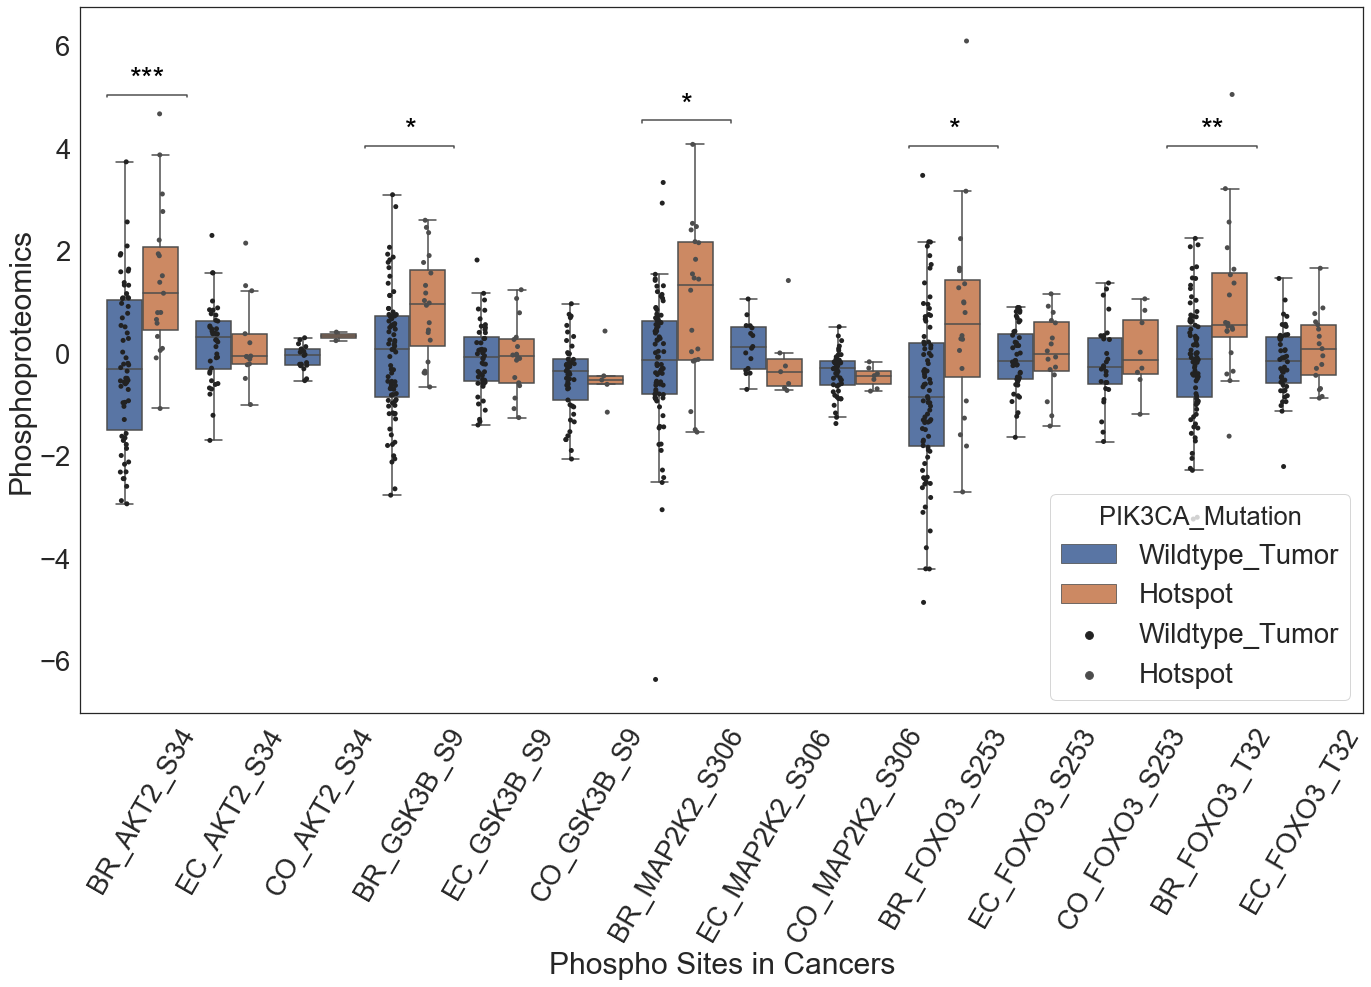

In [14]:
# cis plot
gene = 'PIK3CA'
plt.rcParams['figure.figsize']=(23, 13) #size of plot


sns.set(font_scale = 2.5, style = "white")
boxplot = sns.boxplot(x='cancer_site', y= "Phospho", data = plot_df, hue = 'PIK3CA_Mutation'
                      ,hue_order = ["Wildtype_Tumor", "Hotspot"], order = x_order,  showfliers = False)   
#boxplot.set_title('Pancancer cis effect of PIK3CA Missense')
boxplot = sns.stripplot(x='cancer_site', y= "Phospho", data = plot_df, jitter = True, 
                           color = ".3", hue = 'PIK3CA_Mutation', hue_order = ["Wildtype_Tumor", "Hotspot"], order = x_order, dodge = True)
boxplot.set(xlabel = "Phospho Sites in Cancers", ylabel = 'Phosphoproteomics')
boxplot.set_xticklabels(boxplot.get_xticklabels(),rotation=60)


format_pval_annotation('***', -.4, .5, 5) 
format_pval_annotation('**', 11.5, 12.5, 4) 
format_pval_annotation('*', 5.6, 6.6, 4.5) 
format_pval_annotation('*', 8.6, 9.6, 4) 
format_pval_annotation('*', 2.5, 3.5, 4) 
plt.show()
plt.clf()
plt.close()

In [15]:

fig = boxplot.get_figure()
fig.savefig("PIK3CA_Figure2B.png", dpi = 300,bbox_inches="tight")

In [16]:
#double check FOXO3_T32 and FOXO3_S311 missing in Colon 
Colon_results[Colon_results.Comparison.str.startswith("FOXO3")]

,Comparison,P_Value
75,FOXO3_phosphoproteomics_S425,0.843595
125,FOXO3_phosphoproteomics_S253,0.862146
130,FOXO3_phosphoproteomics_S43,0.862146
166,FOXO3_phosphoproteomics_S284,0.910985
175,FOXO3_phosphoproteomics_S413,0.941245
192,FOXO3_phosphoproteomics_S294,0.962355


In [17]:
#double check FOXO3_S311 missing in Endometrial
Endo_results[Endo_results.Comparison.str.startswith("FOXO3_phosphoproteomics_S311")]

,Comparison,P_Value
